## 第9章 模型设定与数据问题

### 9.4 解释变量个数的选择

In [127]:
import pandas as pd
import statsmodels.api as sm

icecream = pd.read_stata('../2_Data/Data-2e/icecream.dta')
icecream['temp_l1'] = icecream['temp'].shift(1)# 引入temp滞后1期
icecream['temp_l2'] = icecream['temp'].shift(2)# 引入temp滞后2期

def Ols_icecream(data, X_cols:list, y_col:str,lags=0):
    X =  icecream[X_cols]
    y =  icecream[y_col]
    Model = sm.OLS(y[lags:], X[lags:])
    Results = Model.fit()
    return Results

#### 1.IC方法

回归后使用信息准则AIC和BIC，观察AIC和BIC的变化，取最小值对应的模型。

结果：
- 引入滞后1期时，IC最小，因此，解释变量中应引入滞后1期。

In [128]:
Results = Ols_icecream(icecream,
                       ['temp', 'price', 'income'], 
                       'consumption')
Results1 = Ols_icecream(icecream,
                        ['temp', 'temp_l1', 'price', 'income'], 
                        'consumption',
                        1)
Results2 = Ols_icecream(icecream,
                        ['temp', 'temp_l1', 'temp_l2', 'price', 'income'], 
                        'consumption',
                        2)

# 直接调用OLSResults的属性
print(f'【不引入temp滞后项】AIC:{Results.aic:.4f}  BIC:{Results.bic:.4f}') 
print(f'【引入temp滞后1期】AIC:{Results1.aic:.4f}  BIC:{Results1.bic:.4f}') 
print(f'【引入temp滞后2期】AIC:{Results2.aic:.4f}  BIC:{Results2.bic:.4f}') 

【不引入temp滞后项】AIC:-110.6299  BIC:-106.4263
【引入temp滞后1期】AIC:-118.0386  BIC:-112.5694
【引入temp滞后2期】AIC:-111.4727  BIC:-104.8117


#### 2. 序贯t规则

步骤：
- 设置一个最大滞后期，引入所有滞后期进行回归
- 对最大滞后期进行t检验，如不显著就向前推
- 直到找到现在的滞后期为止

结果：
1. temp_l2的p值为0.5374,不显著,不接受此最大滞后项,继续检验p-1期。
2. temp_l1的p值为0.0071,显著,接此最大滞后项。


In [129]:
Results2 = Ols_icecream(icecream,
                        ['temp', 'temp_l1', 'temp_l2', 'price', 'income'], 
                        'consumption',
                        2)

if Results2.pvalues['temp_l2']>0.05:
    print(f"temp_l2的p值为{Results2.pvalues['temp_l2']:.4f},不显著,不接受此最大滞后项,继续检验p-1期。")
else:
    print(f"temp_l2的p值为{Results2.pvalues['temp_l2']:.4f},显著,接此最大滞后项。")

temp_l2的p值为0.5374,不显著,不接受此最大滞后项,继续检验p-1期。


In [130]:
Results1 = Ols_icecream(icecream,
                        ['temp', 'temp_l1', 'price', 'income'], 
                        'consumption',
                        1)

if Results1.pvalues['temp_l1']>0.05:
    print(f"temp_l1的p值为{Results1.pvalues['temp_l1']:.4f},不显著,不接受此最大滞后项,继续检验p-1期。")
else:
    print(f"temp_l1的p值为{Results1.pvalues['temp_l1']:.4f},显著,接此最大滞后项。")

temp_l1的p值为0.0071,显著,接此最大滞后项。


### 9.5 对函数形式的检验

In [131]:
import pandas as pd
import statsmodels.api as sm

grilic = pd.read_stata('../2_Data/Data-2e/grilic.dta')

In [132]:
X = grilic[['s','expr','tenure','smsa','rns']]
y = grilic['lnw']
model = sm.OLS(y,sm.add_constant(X))
Results = model.fit()
print(Results.params)

const     4.103675
s         0.102643
expr      0.038119
tenure    0.035615
smsa      0.139667
rns      -0.084080
dtype: float64


使用拟合值的高次项进行RESET检验，linear_reset()的参数中，test_type参数设置为：
- fitted 拟合值,默认值
- exog  所有解释变量
- princomp 解释变量中的第一个主成分

1.先检测是否遗漏拟合值的高次遗漏项

In [133]:
reset_res = sm.stats.diagnostic.linear_reset(Results,
                                             power=[2,3,4], # 测试2, 3, 4次项加入解释变量 
                                             use_f=True # 使用F统计量
                                             )
reset_res.summary()

'<F test: F=1.5068418352326869, p=0.21140502019856158, df_denom=749, df_num=3>'

接受原假设，即高次项系数为0，就是没有遗漏高次项。

2.再检测是否有解释变量的高次遗漏项

In [134]:
reset_res = sm.stats.diagnostic.linear_reset(Results,
                                             test_type='exog',
                                             power=[2,3,4], # 测试2, 3, 4次项加入解释变量 
                                             use_f=True # 使用F统计量
                                             )
reset_res.summary()

'<F test: F=2.03045143326775, p=0.03360894633210033, df_denom=743, df_num=9>'

拒绝了原假设, 说明有遗漏高次项情况，但是并不知道是哪个解释变量导致了这一结果。继续对解释变量的首要影响因素进行检测。

不知道哪个是主要成分，如何识别？
- 对所有解释变量都进行循环检验
  - 如果高次项系数显著（t检验p值 < 0.05）
  - 所有解释变量的RESET检验结果不显著(p值 > 0.05)

则可认为应该加入这个解释变量的高次项。

测试的结果是，这个思路不行。。。

In [135]:
reset_res = sm.stats.diagnostic.linear_reset(Results,
                                             test_type='princomp',
                                             power=[2,3,4], # 测试2, 3, 4次项加入解释变量 
                                             use_f=True # 使用F统计量
                                             )
reset_res.summary()

'<F test: F=4.4748085700701195, p=0.004003746624692338, df_denom=749, df_num=3>'

#### RESET检验

In [136]:

icecream = pd.read_stata('../2_Data/Data-2e/grilic.dta')

def reset(dataset, X_cols, y_col):
    """
    对拟合值、全体解释变量、不同的解释变量进行RESET检测.
    并显示可识别检测对象的判断结果
    """
    X = dataset[X_cols]
    y = dataset[y_col]
    X = sm.add_constant(X)
    Results_y = sm.OLS(y, X).fit()
    reset_y = sm.stats.diagnostic.linear_reset(Results,
                                                 power=[2,3,4],use_f=True)
    reset_X = sm.stats.diagnostic.linear_reset(Results, test_type='exog',
                                                 power=[2,3,4],use_f=True)
    reset_prin = sm.stats.diagnostic.linear_reset(Results,
                                                         test_type='princomp',
                                                         power=[2,3,4],use_f=True)
    print("被解释变量的RESET检测结果:",reset_y)
    print("全体解释变量的RESET检测结果:",reset_X)
    print('解释变量主成分的RESET检测结果:',reset_prin)
    x2_list = []
    
    for i in X_cols:
        i2 = i+'2'
        dataset[i2] = dataset[i]**2
        X = dataset[X_cols+[i2]]
        # print(X_cols+[i2])
        Results_new = sm.OLS(y, sm.add_constant(X)).fit()
        print(Results_new.params[i2])
        reset_new = sm.stats.diagnostic.linear_reset(Results_new,
                                                         test_type='princomp',
                                                         power=[2,3,4],use_f=True)
        print(f'加入{i}的2次项的RESET检测结果:',reset_new.pvalue)
        if reset_new.pvalue < 0.05 and Results_new.params[i2] > 0.05:
            x2_list.append(i2)
    
    print(f'加入2次项后,可考虑引入{x2_list}:')    
        
reset(dataset=grilic, X_cols=['s','expr','tenure','smsa','rns'], y_col='lnw')    

被解释变量的RESET检测结果: <F test: F=1.5068418352326869, p=0.21140502019856158, df_denom=749, df_num=3>
全体解释变量的RESET检测结果: <F test: F=2.03045143326775, p=0.03360894633210033, df_denom=743, df_num=9>
解释变量主成分的RESET检测结果: <F test: F=4.4748085700701195, p=0.004003746624692338, df_denom=749, df_num=3>
0.00033273358687158224
加入s的2次项的RESET检测结果: 0.03038086400306814
0.0051818814916269615
加入expr的2次项的RESET检测结果: 0.004037117770440055
0.007679465049032812
加入tenure的2次项的RESET检测结果: 0.04327193516213031
0.06983331759564565
加入smsa的2次项的RESET检测结果: 0.2823485794581052
-0.04203987029284524
加入rns的2次项的RESET检测结果: 0.04747189915845505
加入2次项后,可考虑引入[]:


### 9.6 多重共线性

可能涉及到Stata与Python内部的计算机制不一样，同样的数据计算的结果不一样，但是不影响判断。
在后面的计算中，pd.read_stata()函数读取Stata文件时，会出现值较小的数据使用int8类型的情况，这样会造成在计算过程中数据不足的情况，这样会导致计算结果出现大幅偏差的情况。

解决方法：
- 读取数据后直接全部提成64位浮点数，或者使用pandas的astype()函数转换数据类型。

#### VIF方差膨胀因子

In [137]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(exog, criterion=5):
    '''vif df格式输出
    计算解释变量的方差膨胀因子和容忍度,其中解释变量不含有常数项
    返回：
        解释变量vif值、容忍度的dataframe 
    Arguments:
        exog -- 解释变量:dataframe
        criterion -- 方差膨胀因子阈值,默认5
    '''
    multicol = pd.DataFrame()
    multicol['变量'] = exog.columns
    multicol['方差膨胀因子'] = [variance_inflation_factor(exog.values, i) for i in range(exog.shape[1])]
    multicol['容忍度'] = 1/multicol['方差膨胀因子']
    _ = []
    for i in multicol['方差膨胀因子']:
        if i > criterion:
            _.append('**是**')
        else:
            _.append('否')    
    multicol['是否多重共线'] = _
    return multicol

grilic = pd.read_stata('../2_Data/Data-2e/grilic.dta')
X = grilic[['s','expr','tenure','smsa','rns']]
vif_1 = vif(X)
# for i in vif:
#     print(vif[i].dtype)
vif_1

,变量,方差膨胀因子,容忍度,是否多重共线
0,s,4.973077,0.201083,否
1,expr,1.698322,0.588816,否
2,tenure,2.288772,0.436916,否
3,smsa,3.417113,0.292645,否
4,rns,1.364364,0.732942,否


引入平方项，易引起多重共线。

注意：这里出现了一个数据类型转换的问题

例如：

In [138]:
# 转换数据类型
cols_to_convert = X.select_dtypes(include=['int8'])
for col in cols_to_convert:
    X[col] = X[col].astype('float32')

# 生成s的平方项
X['s2'] = X['s'] ** 2
X

C:\Users\NINGMEI\AppData\Local\Temp\ipykernel_21428\1584946888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('float32')
C:\Users\NINGMEI\AppData\Local\Temp\ipykernel_21428\1584946888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('float32')
C:\Users\NINGMEI\AppData\Local\Temp\ipykernel_21428\1584946888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,s,expr,tenure,smsa,rns,s2
0,12.0,0.462,0.0,1.0,0.0,144.0
1,16.0,0.000,2.0,1.0,0.0,256.0
2,14.0,0.423,1.0,1.0,0.0,196.0
3,12.0,0.333,1.0,1.0,0.0,144.0
4,9.0,9.013,3.0,1.0,0.0,81.0
...,...,...,...,...,...,...
753,16.0,0.000,1.0,1.0,1.0,256.0
754,12.0,0.692,1.0,0.0,1.0,144.0
755,12.0,4.828,0.0,0.0,1.0,144.0
756,12.0,2.489,2.0,0.0,1.0,144.0


In [139]:
vif_2 = vif(X)
vif_2

,变量,方差膨胀因子,容忍度,是否多重共线
0,s,60.913912,0.016417,**是**
1,expr,1.857611,0.538326,否
2,tenure,2.328171,0.429522,否
3,smsa,3.502414,0.285517,否
4,rns,1.401529,0.713506,否
5,s2,46.852452,0.021344,**是**


结果显示s和s2都有多重共线性

In [140]:
X['sd'] = (X['s']-X['s'].mean())/X['s'].std()
X['sd2'] = X['sd']**2
for i in ['s','s2']:
    if i in X:   
        X.drop(i, axis=1, inplace=True)
X

C:\Users\NINGMEI\AppData\Local\Temp\ipykernel_21428\3802650683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sd'] = (X['s']-X['s'].mean())/X['s'].std()
C:\Users\NINGMEI\AppData\Local\Temp\ipykernel_21428\3802650683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sd2'] = X['sd']**2
C:\Users\NINGMEI\AppData\Local\Temp\ipykernel_21428\3802650683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

,expr,tenure,smsa,rns,sd,sd2
0,0.462,0.0,1.0,0.0,-0.629535,0.396314
1,0.000,2.0,1.0,0.0,1.162718,1.351913
2,0.423,1.0,1.0,0.0,0.266592,0.071071
3,0.333,1.0,1.0,0.0,-0.629535,0.396314
4,9.013,3.0,1.0,0.0,-1.973724,3.895586
...,...,...,...,...,...,...
753,0.000,1.0,1.0,1.0,1.162718,1.351913
754,0.692,1.0,0.0,1.0,-0.629535,0.396314
755,4.828,0.0,0.0,1.0,-0.629535,0.396314
756,2.489,2.0,0.0,1.0,-0.629535,0.396314


In [141]:
vif(X)

,变量,方差膨胀因子,容忍度,是否多重共线
0,expr,1.804305,0.554230,否
1,tenure,2.038801,0.490484,否
2,smsa,2.079105,0.480976,否
3,rns,1.271753,0.786316,否
4,sd,1.299687,0.769416,否
5,sd2,2.029292,0.492783,否


### 9.9 经济结构变动的检验

邹检验 & 引入虚拟变量法

#### 1.chow检验

statsmodel包中没有专门的chow检验函数。

##### （1）画图

0     3912484.0
1     3916441.0
2     3920400.0
3     3924361.0
4     3928324.0
5     3932289.0
6     3936256.0
7     3940225.0
8     3944196.0
9     3948169.0
10    3952144.0
11    3956121.0
12    3960100.0
13    3964081.0
14    3968064.0
15    3972049.0
16    3976036.0
17    3980025.0
18    3984016.0
19    3988009.0
20    3992004.0
21    3996001.0
22    4000000.0
23    4004001.0
24    4008004.0
25    4012009.0
26    4016016.0
27    4020025.0
28    4024036.0
29    4028049.0
30    4032064.0
31    4036081.0
32    4040100.0
33    4044121.0
34    4048144.0
35    4052169.0
Name: year, dtype: float64
0     1.453363e+05
1     1.757706e+05
2     2.146006e+05
3     2.422215e+05
4     2.785518e+05
5     3.395160e+05
6     4.833031e+05
7     7.358552e+05
8     9.277350e+05
9     1.237389e+06
10    1.864618e+06
11    2.307361e+06
12    2.702736e+06
13    3.582540e+06
14    5.341137e+06
15    8.990163e+06
16    1.635394e+07
17    2.545939e+07
18    3.417443e+07
19    4.121871e+07
20    4.618602e+0

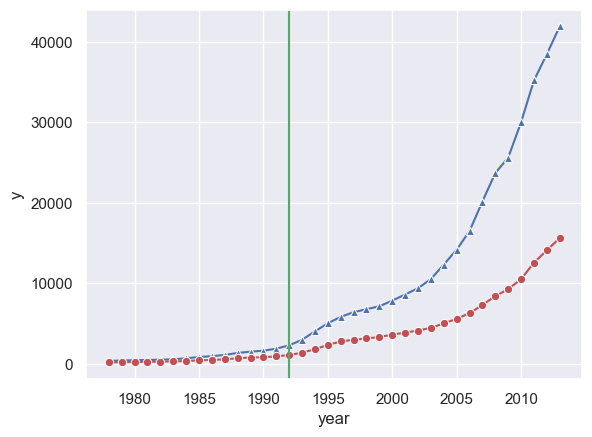

In [142]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
consump = pd.read_stata('../2_Data/Data-2e/consumption.dta')

## 画图
sns.set_theme(style="darkgrid")
sns.lineplot(x='year', y='y', data=consump,marker='^',markers=True)
sns.lineplot(x='year', y='c', data=consump,color='r',marker='o',markers=True)
plt.axvline(x=1992, color='g', linestyle='-')

breakpoint = consump[consump['year']==1992].index[0]

for i in consump.columns:
    print(consump[i].astype('float64')**2)

##### （2）检验
从图形上看，确实存在结构性变化的可能。

In [143]:
# model fit
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

def chow_test(dataset, X_cols, y_col, breakpoint):
    '''chow_test 对某个回归进行邹志庄检验.
    原假设：分段与总体的回归系数一致，不存在结构变化
    Arguments:
        dataset -- dataframe,变量数据
        X_cols -- list,自变量列名
        y_col -- str,因变量列名
        breakpoint -- float,用于指定分界点.
    Returns:
        F -- float,邹志庄检验的F值.
        p_value -- float,邹志庄检验的p值.
        result -- str,邹志庄检验的结果.
    '''
    dataset1 =  dataset[:breakpoint]
    dataset2 =  dataset[breakpoint:]
    ssr_list = []
    model_res = []
    for d in [dataset, dataset1, dataset2]:
        X = d[X_cols].astype('float64')
        y = d[y_col].astype('float64')
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        ssr_list.append(results.ssr)
        model_res.append(results)
    n = dataset.shape[0]
    k = len(X_cols) + 1 # 加入常数项的自由度
    F = ((n-2*k)/k)*((ssr_list[0]-ssr_list[1]-ssr_list[2])/(ssr_list[1]+ssr_list[2]))
    p_value = 1 - stats.f.cdf(F, k, n-2*k)
    if p_value < 0.05:
        result = '拒绝原假设，存在结构变化'
    else:
        result = '接受原假设，不存在结构变化'
    return F,p_value,result

In [144]:
ddd = chow_test(dataset=consump, 
          X_cols=['y'], y_col='c', 
          breakpoint=consump[consump['year']==1992].index[0])
ddd

(15.39455829646676, 2.0713318724996377e-05, '拒绝原假设，存在结构变化')

#### 2.引入虚拟变量



In [152]:

import pandas as pd
import statsmodels.api as sm

# 生成虚拟变量d，和交互项yd
consp = pd.read_stata('../2_Data/Data-2e/consumption.dta')
consp['d'] = [0 if year < 1992 else 1 for year in consp['year']]
consp['yd'] = consp['y'] * consp['d']
consp
# 回归
X = consp[['y', 'd', 'yd']]
y = consp['c']
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4405.
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           6.20e-42
Time:                        13:11:25   Log-Likelihood:                -242.55
No. Observations:                  36   AIC:                             493.1
Df Residuals:                      32   BIC:                             499.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8912    123.918      0.104      0.9

##### （1）F检验进行联合显著性检验

在使用f_test()时，需要将原假设设置正确，否则自由度会出现偏差，导致计算结果出错。

In [153]:
import numpy as np
# (4) rain 和 coast 联合显著性
hypotheses = '(d = 0), (yd = 0)'
f_test = results.f_test(hypotheses)
f_test.summary()

if f_test.pvalue < 0.05:
    print("因p值为{:.4f}小于显著性水平,拒绝原假设".format(f_test.pvalue))
else:
    print("因p值为{:.4f}大于显著性水平,不能拒绝原假设".format(f_test.pvalue))
print(f_test.summary())

因p值为0.0000小于显著性水平,拒绝原假设
<F test: F=15.394558296539689, p=2.071331872427543e-05, df_denom=32, df_num=2>


此结果需要在同方差和自相关的情况下成立，因此还要使用：
- 异方差：White检验
- 自相关：BG检验

##### （2）异方差检验：white检验
拒绝原假设：存在异方差

In [154]:
from statsmodels.stats.diagnostic import het_white

result_white = het_white(resid=results.resid, exog=X)
result_white

(18.550915603766995,
 0.002329603474294182,
 6.378873016777381,
 0.00038046265933111935)

##### （3）自相关检验：BG检验

In [155]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

lag = 1  # 假设我们检验1阶自相关
bg_result = acorr_breusch_godfrey(results, nlags=lag)
print("BG检验的LM统计量:{:.4f}".format(bg_result[0]))
print("BG检验的LM统计量P值:{:.4f}".format(bg_result[1]))
if bg_result[1]<0.05:
    print("拒绝原假设,模型存在自相关.")
else:
    print("接受原假设，模型不存在自相关.")


BG检验的LM统计量:21.4828
BG检验的LM统计量P值:0.0000
拒绝原假设,模型存在自相关.


##### （4）NW法

OLS+异方差自相关稳健的标准误（HAC）


In [156]:
nw_cov_type = 'HAC'
p = int((len(consp)** 0.25 // 1) + 1)
nw_kwargs = {'maxlags': p,'use_correction':True}
nw_res = results.get_robustcov_results(cov_type=nw_cov_type, use_t=True, **nw_kwargs)
print(nw_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2455.
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           6.93e-38
Time:                        13:12:21   Log-Likelihood:                -242.55
No. Observations:                  36   AIC:                             493.1
Df Residuals:                      32   BIC:                             499.4
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8912     10.166      1.268      0.2

##### （5）对新回归进行联合显著性检验

In [158]:
hypotheses = '(d = 0), (yd = 0)'
f_test = nw_res.f_test(hypotheses)
f_test.summary()

if f_test.pvalue < 0.05:
    print("因p值为{:.4f}小于显著性水平,拒绝原假设".format(f_test.pvalue))
else:
    print("因p值为{:.4f}大于显著性水平,不能拒绝原假设".format(f_test.pvalue))
print(f_test.summary())

因p值为0.0000小于显著性水平,拒绝原假设
<F test: F=73.05469132974434, p=1.17872061607885e-12, df_denom=32, df_num=2>
